In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn as sklearn
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Load processed data features
data_features = pd.read_csv('processed_data/data_features.csv', header=[0,1], index_col=0, parse_dates=True)
# Forward fill missing values
data_features = data_features.ffill()

# Quick look at the data
print('features :' + str(data_features.keys().get_level_values(1).unique()))
data_features.head()

features :Index(['Stochastic', 'William', 'Basic_Mid', 'Close_to_High', 'Close_to_Low',
       'DD_Return', 'Close_MA_5', 'Close_STD_5', 'Close_GROWTH_5',
       'Close_Above_MA_5',
       ...
       'Low_GROWTH_150', 'Low_Above_TREND_150', 'Low_Above_STD_150',
       'Close_CORR_5', 'Close_CORR_10', 'Close_CORR_15', 'Close_CORR_35',
       'Close_CORR_40', 'Close_CORR_45', 'Signal'],
      dtype='object', length=148)


CDE                                                  \
           Stochastic   William  Basic_Mid Close_to_High Close_to_Low   
Date                                                                    
2005-01-03   0.090908  0.909092  38.100000      0.026455    -0.002645   
2005-01-04   0.142857  0.857143  36.600000      0.049862    -0.008310   
2005-01-05   0.125001  0.874999  36.300001      0.038997    -0.005571   
2005-01-06   0.210527  0.789473  35.366666      0.042857    -0.011429   
2005-01-07   0.499998  0.500002  35.300001      0.016997    -0.016997   

                                                                             \
           DD_Return Close_MA_5 Close_STD_5 Close_GROWTH_5 Close_Above_MA_5   
Date                                                                          
2005-01-03       NaN        NaN         NaN            NaN                0   
2005-01-04 -0.044974        NaN         NaN            NaN                0   
2005-01-05 -0.005540        NaN         NaN            NaN                0   
2005-01-06 -0.025070        NaN         NaN            NaN                0   
2005-01-07  0.008571   1.020397    0.030247            NaN                1   

            ...           LRCX                                        \
            ... Low_GROWTH_150 Low_Above_TREND_150 Low_Above_STD_150   
Date        ...                                                        
2005-01-03  ...            NaN                   0                 0   
2005-01-04  ...            NaN                   0                 0   
2005-01-05  ...            NaN                   0                 0   
2005-01-06  ...            NaN                   0                 0   
2005-01-07  ...            NaN                   0                 0   

                                                                   \
           Close_CORR_5 Close_CORR_10 Close_CORR_15 Close_CORR_35   
Date                                                                
2005-01-03          NaN           NaN           NaN           NaN   
2005-01-04          NaN           NaN           NaN           NaN   
2005-01-05          NaN           NaN           NaN           NaN   
2005-01-06          NaN           NaN           NaN           NaN   
2005-01-07          NaN           NaN           NaN           NaN   

                                               
           Close_CORR_40 Close_CORR_45 Signal  
Date                                           
2005-01-03           NaN           NaN      0  
2005-01-04           NaN           NaN     -1  
2005-01-05           NaN           NaN     -1  
2005-01-06           NaN           NaN     -1  
2005-01-07           NaN           NaN      0  

[5 rows x 20424 columns]

In [11]:
# Filter data_features to include only rows after the date N due to feature availability
N = 151
filtered_data = data_features[data_features.index > data_features.index[N]]
filtered_data = filtered_data[filtered_data.index < filtered_data.index[(252*4)]]
first_date = filtered_data.index.min()
last_date = filtered_data.index.max()
print(f'Data filtered to include only rows after {first_date}')
print(f"Data filtered to include only rows before {last_date}")

Data filtered to include only rows after 2005-08-10 00:00:00
Data filtered to include only rows before 2009-08-11 00:00:00


In [12]:
# find best features using SelectKBest on every ticker and keep most frequent features

most_frequent_features = []
k_best_features = 34
required_col = 'DD_Return'

for ticker in filtered_data.columns.get_level_values(0).unique():
    X = filtered_data[ticker].drop(columns=['Signal'])
    Y = filtered_data[ticker]['Signal']
    
    selector_var = VarianceThreshold(threshold=0.01)
    X_var = selector_var.fit_transform(X)
    selector = SelectKBest(score_func=f_classif, k=k_best_features)
    selector.fit(X_var, Y)
    
    selected_features = X.columns[selector.get_support(indices=True)].tolist()
    # Ensure required_col is included
    if required_col not in selected_features:
        selected_features.append(required_col)
    
    most_frequent_features.extend(selected_features)

# add Signal column to most frequent features
most_frequent_features.append('Signal')

most_frequent_features = pd.Series(most_frequent_features).value_counts()
most_frequent_features = most_frequent_features.head(100).index.tolist()
print("Most frequent features selected across all tickers:")
print(most_frequent_features)

Most frequent features selected across all tickers:
['Stochastic', 'William', 'DD_Return', 'Close_GROWTH_5', 'Close_MA_40', 'Close_Above_MA_35', 'Close_MA_5', 'Close_STD_40', 'Close_Above_STD_40', 'Close_GROWTH_40', 'Close_Above_STD_35', 'Close_Above_MA_15', 'Close_STD_15', 'Close_STD_45', 'Close_GROWTH_15', 'Close_Above_STD_5', 'Close_STD_5', 'Close_Above_MA_45', 'Close_Above_MA_40', 'Close_MA_15', 'Close_MA_45', 'Close_Above_MA_10', 'Close_GROWTH_35', 'Close_MA_10', 'Close_Above_STD_45', 'Close_STD_35', 'Close_Above_STD_10', 'Close_Above_STD_15', 'Close_Above_MA_5', 'Close_GROWTH_45', 'Basic_Mid', 'Close_GROWTH_10', 'Close_MA_35', 'Close_STD_10', 'High_GROWTH_5', 'High_MA_5', 'High_STD_5', 'Close_to_Low', 'High_Above_MA_5', 'High_Above_STD_5', 'High_STD_10', 'High_MA_10', 'High_Above_MA_10', 'High_GROWTH_10', 'High_MA_15', 'High_STD_15', 'High_Above_STD_10', 'Close_to_High', 'High_GROWTH_15', 'High_Above_MA_15', 'High_MA_35', 'High_STD_35', 'High_Above_MA_35', 'High_Above_STD_15', 'H

In [13]:
# Remove unseen feature from filtered_data
filtered_data = filtered_data.loc[:, (slice(None), most_frequent_features)]

In [34]:
# Fit model and parameters for each period and ticker

duration_period = 1/2 # % year
window_size = int(252 * duration_period)

Nestimator_grid = np.linspace(100, 100, 1, dtype=int)

filtered_data = filtered_data.ffill()
Tickers = filtered_data.columns.get_level_values(0).unique()
tscv_nSplit = len(filtered_data) // window_size - 1

tscv = TimeSeriesSplit(n_splits=tscv_nSplit, max_train_size=window_size)

metrics_perf = []
current_step = 0
total_steps = tscv.get_n_splits(filtered_data)

for train_index, test_index in tscv.split(filtered_data):
    print(f'Processing fold {current_step + 1} of {total_steps}', end=' | ')
    print(f'Start Train: {filtered_data.index[train_index].min()} | End Train: {filtered_data.index[train_index].max()} | Start Test: {filtered_data.index[test_index].min()} | End Test: {filtered_data.index[test_index].max()}')
    current_step += 1

    train_data, test_data = filtered_data.iloc[train_index], filtered_data.iloc[test_index]

    for ticker in Tickers:
        
        X_train, Y_train = train_data[ticker].drop(columns=['Signal']), train_data[ticker]['Signal']
        X_test, Y_test = test_data[ticker].drop(columns=['Signal']), test_data[ticker]['Signal']
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        X_train_DD_Return = X_train['DD_Return']
        X_test_DD_Return = X_test['DD_Return']
        del X_train, X_test

        grid_search = GridSearchCV(
            RandomForestClassifier(random_state=42, n_jobs=-1),
            param_grid={'n_estimators': Nestimator_grid,
                        'max_depth': [5],
                        'min_samples_split': [50],
                        'min_samples_leaf': [1],
                        'max_features': ['sqrt']
                        },
            scoring='accuracy',
            cv=TimeSeriesSplit(n_splits=2, max_train_size=window_size),
            n_jobs=-1
        )

        grid_search.fit(X_train_scaled, Y_train)

        best_n_estimators = grid_search.best_params_['n_estimators']
        best_model = grid_search.best_estimator_

        Y_train_pred_src = best_model.predict(X_train_scaled)
        Y_test_pred_src = best_model.predict(X_test_scaled)

        del X_train_scaled, X_test_scaled

        # Find optimal triggers based on performance metrics
        best_trigger_up = None
        best_trigger_down = None
        best_return_train = -np.inf
        best_return_test = -np.inf

        Return_test = np.array(X_test_DD_Return.shift(-1).fillna(0))
        Return_train = np.array(X_train_DD_Return.shift(-1).fillna(0))

        # Evaluate performance
        return_predicted_train = float(np.sum(Y_train_pred_src * Return_train))
        return_predicted_test = float(np.sum(Y_test_pred_src * Return_test))

        if return_predicted_train > best_return_train:
            best_return_train = return_predicted_train
            best_return_test = return_predicted_test

        best_market_return_test = float(np.sum(Return_test))
        best_market_return_train = float(np.sum(Return_train))

        metrics_perf.append({
            'Ticker': ticker,
            'Train Start': train_data.index.min(),
            'Train End': train_data.index.max(),
            'Test Start': test_data.index.min(),
            'Test End': test_data.index.max(),
            'Return_Predicted_Train': best_return_train,
            'Return_Predicted_Test': best_return_test,
            'Market_Return_Train': best_market_return_train,
            'Market_Return_Test': best_market_return_test,
            'Ratio_Train': best_return_train / best_market_return_train if best_market_return_train != 0 else 0,
            'Model_train_>_Market_train': 1 if best_return_train > best_market_return_train else 0,
            'Model_test_>_Market_test': 1 if best_return_test > best_market_return_test else 0,
            'n_estimators': best_n_estimators,
            'max_depth': grid_search.best_params_.get('max_depth', None),
            'min_samples_split': grid_search.best_params_.get('min_samples_split', None),
            'min_samples_leaf': grid_search.best_params_.get('min_samples_leaf', None),
            'max_features': grid_search.best_params_.get('max_features', None)
        })

metrics_perf_df = pd.DataFrame(metrics_perf)
metrics_perf_df.to_csv('model/randomforest/metrics_raw_data.csv', index=False)
metrics_perf_df

Processing fold 1 of 7 | Start Train: 2005-08-10 00:00:00 | End Train: 2006-02-08 00:00:00 | Start Test: 2006-02-09 00:00:00 | End Test: 2006-08-09 00:00:00
Processing fold 2 of 7 | Start Train: 2006-02-09 00:00:00 | End Train: 2006-08-09 00:00:00 | Start Test: 2006-08-10 00:00:00 | End Test: 2007-02-09 00:00:00
Processing fold 3 of 7 | Start Train: 2006-08-10 00:00:00 | End Train: 2007-02-09 00:00:00 | Start Test: 2007-02-12 00:00:00 | End Test: 2007-08-10 00:00:00
Processing fold 4 of 7 | Start Train: 2007-02-12 00:00:00 | End Train: 2007-08-10 00:00:00 | Start Test: 2007-08-13 00:00:00 | End Test: 2008-02-11 00:00:00
Processing fold 5 of 7 | Start Train: 2007-08-13 00:00:00 | End Train: 2008-02-11 00:00:00 | Start Test: 2008-02-12 00:00:00 | End Test: 2008-08-11 00:00:00
Processing fold 6 of 7 | Start Train: 2008-02-12 00:00:00 | End Train: 2008-08-11 00:00:00 | Start Test: 2008-08-12 00:00:00 | End Test: 2009-02-10 00:00:00
Processing fold 7 of 7 | Start Train: 2008-08-12 00:00:00 

,Ticker,Train Start,Train End,Test Start,Test End,Return_Predicted_Train,Return_Predicted_Test,Market_Return_Train,Market_Return_Test,Ratio_Train,Model_train_>_Market_train,Model_test_>_Market_test,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features
0,CDE,2005-08-10,2006-02-08,2006-02-09,2006-08-09,-0.412026,0.435533,0.300212,0.137555,-1.372449,0,1,100,5,50,1,sqrt
1,ORCL,2005-08-10,2006-02-08,2006-02-09,2006-08-09,-0.101342,-0.074683,-0.047155,0.174509,2.149122,0,0,100,5,50,1,sqrt
2,AMZN,2005-08-10,2006-02-08,2006-02-09,2006-08-09,0.310525,0.169678,-0.128166,-0.322362,-2.422830,1,1,100,5,50,1,sqrt
3,ASX,2005-08-10,2006-02-08,2006-02-09,2006-08-09,-0.012017,-0.221564,0.282409,-0.008641,-0.042553,0,0,100,5,50,1,sqrt
4,PTEN,2005-08-10,2006-02-08,2006-02-09,2006-08-09,-0.192797,0.594362,0.053550,-0.106292,-3.600327,0,1,100,5,50,1,sqrt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,VALE,2008-08-12,2009-02-10,2009-02-11,2009-08-11,0.936477,-0.281591,-0.038747,0.356429,-24.169000,1,0,100,5,50,1,sqrt
962,TJX,2008-08-12,2009-02-10,2009-02-11,2009-08-11,-0.294489,-0.001108,-0.416638,0.515084,0.706821,1,0,100,5,50,1,sqrt
963,CRM,2008-08-12,2009-02-10,2009-02-11,2009-08-11,-0.434470,0.561415,-0.747230,0.550385,0.581441,1,1,100,5,50,1,sqrt
964,NFLX,2008-08-12,2009-02-10,2009-02-11,2009-08-11,-0.733882,-0.285902,0.305670,0.297198,-2.400894,0,0,100,5,50,1,sqrt


In [35]:
# lets compute the average Return_Predicted_Train and Return_Predicted_Test for Train Start dates batch
summary_graph_raw = metrics_perf_df.groupby(['Train Start', 'Train End', 'Test Start', 'Test End']).agg({
    'Return_Predicted_Train': 'mean',
    'Market_Return_Train': 'mean',
    'Return_Predicted_Test': 'mean',
    'Market_Return_Test': 'mean',
})
summary_graph_raw.to_csv('model/randomforest/metrics_raw_summary.csv', index=True)
summary_graph_raw

,,,,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
Train Start,Train End,Test Start,Test End,,,,
2005-08-10,2006-02-08,2006-02-09,2006-08-09,-0.050918,0.140321,0.003313,0.021943
2006-02-09,2006-08-09,2006-08-10,2007-02-09,0.025171,0.021943,-0.046344,0.147916
2006-08-10,2007-02-09,2007-02-12,2007-08-10,-0.028873,0.147916,-0.086778,0.068306
2007-02-12,2007-08-10,2007-08-13,2008-02-11,-0.080293,0.068306,-0.122800,-0.011287
2007-08-13,2008-02-11,2008-02-12,2008-08-11,-0.150018,-0.011287,-0.238446,0.026329
2008-02-12,2008-08-11,2008-08-12,2009-02-10,-0.234947,0.026329,-0.389549,-0.238975
2008-08-12,2009-02-10,2009-02-11,2009-08-11,-0.334786,-0.238975,-0.116056,0.382444


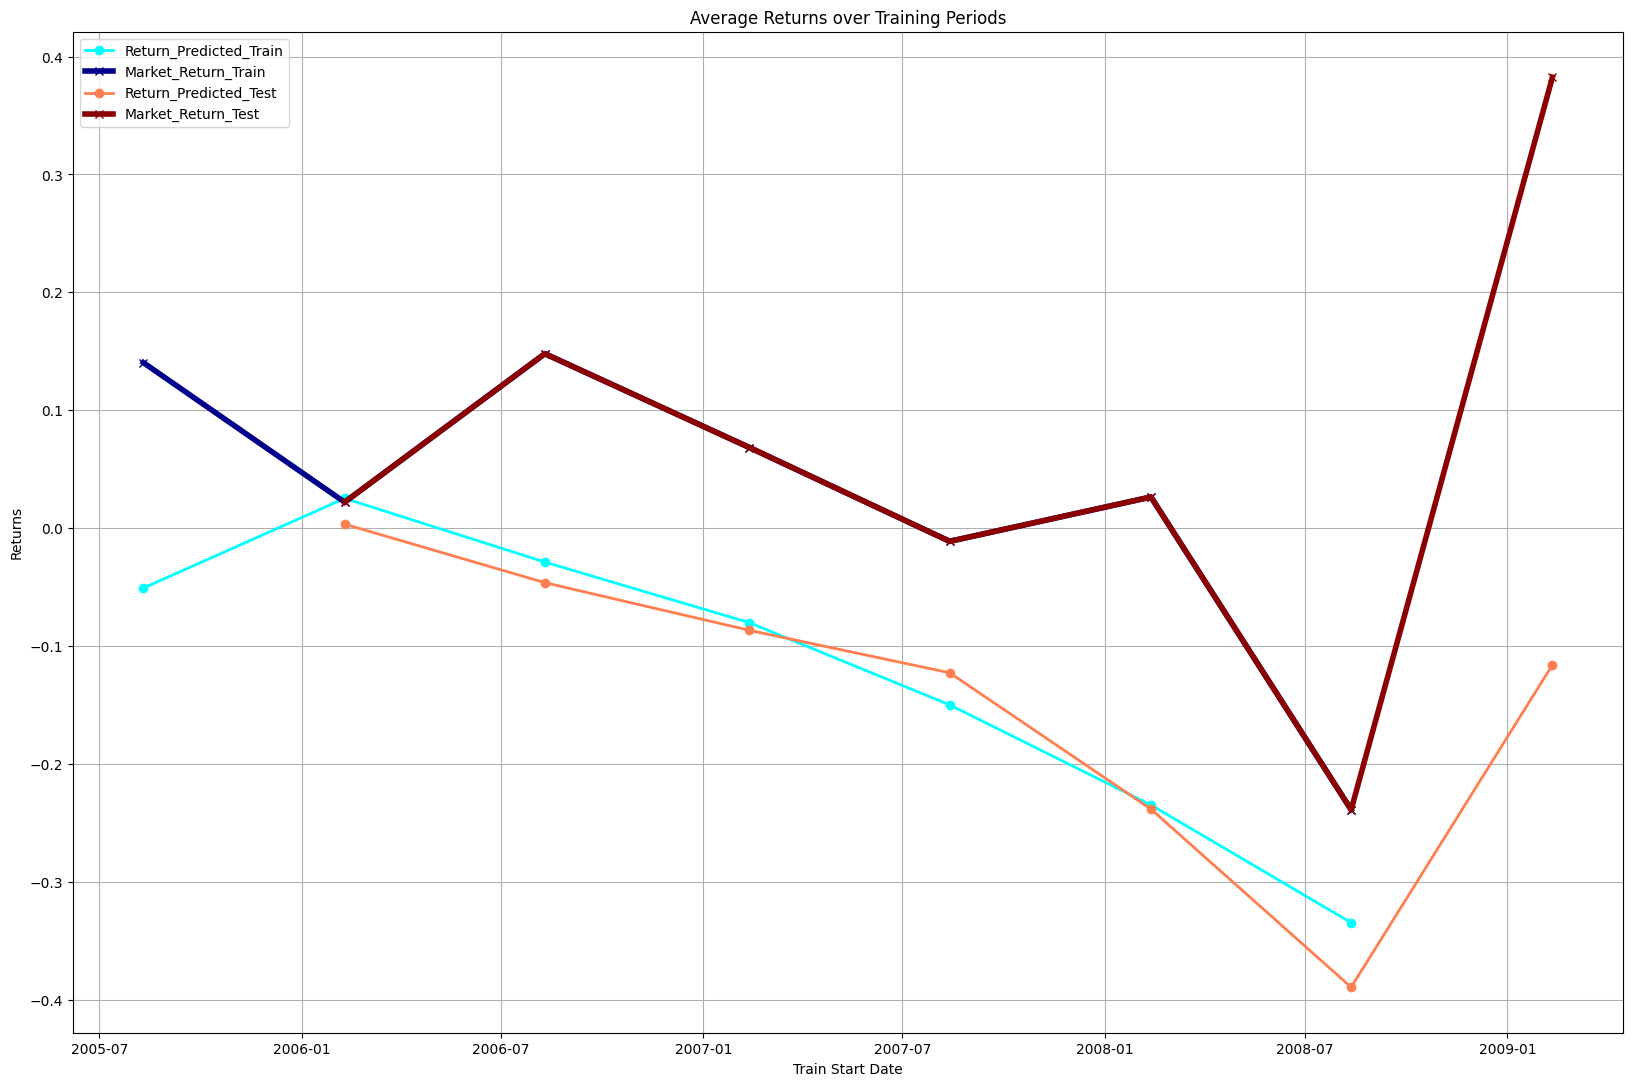

In [36]:
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(summary_graph_raw.index.get_level_values('Train Start'), summary_graph_raw['Return_Predicted_Train'], label='Return_Predicted_Train', marker='o', linewidth=linewidth_model, color='cyan')
plt.plot(summary_graph_raw.index.get_level_values('Train Start'), summary_graph_raw['Market_Return_Train'], label='Market_Return_Train', marker='x', linewidth=linewidth_market, color='darkblue')
plt.plot(summary_graph_raw.index.get_level_values('Test Start'), summary_graph_raw['Return_Predicted_Test'], label='Return_Predicted_Test', marker='o', linewidth=linewidth_model, color='coral')
plt.plot(summary_graph_raw.index.get_level_values('Test Start'), summary_graph_raw['Market_Return_Test'], label='Market_Return_Test', marker='x', linewidth=linewidth_market, color='darkred')
plt.xlabel('Train Start Date')
plt.ylabel('Returns')
plt.title('Average Returns over Training Periods')
plt.legend()
plt.grid()
plt.show()

In [23]:
# Compute yield and std for each series from summary_graph

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    yields_raw = summary_graph_raw[serie].values
    mean_yield_raw = np.mean(yields_raw)
    std_yield_raw = np.std(yields_raw)
    sharpe_ratio_raw = mean_yield_raw / std_yield_raw if std_yield_raw != 0 else 0
    print(f"{serie} - Mean Yield: {mean_yield_raw:.4f}, Std Dev: {std_yield_raw:.4f}, Sharpe Ratio: {sharpe_ratio_raw:.4f}")

Return_Predicted_Train - Mean Yield: -0.0808, Std Dev: 0.0826, Sharpe Ratio: -0.9783
Market_Return_Train - Mean Yield: 0.0221, Std Dev: 0.1203, Sharpe Ratio: 0.1836
Return_Predicted_Test - Mean Yield: -0.1301, Std Dev: 0.1086, Sharpe Ratio: -1.1983
Market_Return_Test - Mean Yield: 0.0567, Std Dev: 0.1727, Sharpe Ratio: 0.3282


In [24]:
# Compute P&L evolution over time for each series
Start_dates = summary_graph_raw.index.get_level_values('Test Start')
End_dates = summary_graph_raw.index.get_level_values('Test End')

Start_End_dates = zip(Start_dates, End_dates)
# Compute P&L evolution over time for each series
PNL_data_raw = summary_graph_raw.reset_index()[['Test Start', 'Test End', 'Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']].rename(columns={'Test Start': 'Start', 'Test End': 'End'})
for start, end in Start_End_dates:
    for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
        PNL_data_raw.loc[(PNL_data_raw['Start'] == start) & (PNL_data_raw['End'] == end), serie] = summary_graph_raw.loc[(summary_graph_raw.index.get_level_values('Test Start') == start) & (summary_graph_raw.index.get_level_values('Test End') == end), serie].values[0]

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    PNL_data_raw[serie] = np.exp(PNL_data_raw[serie])
    PNL_data_raw[serie] = PNL_data_raw[serie].cumprod()

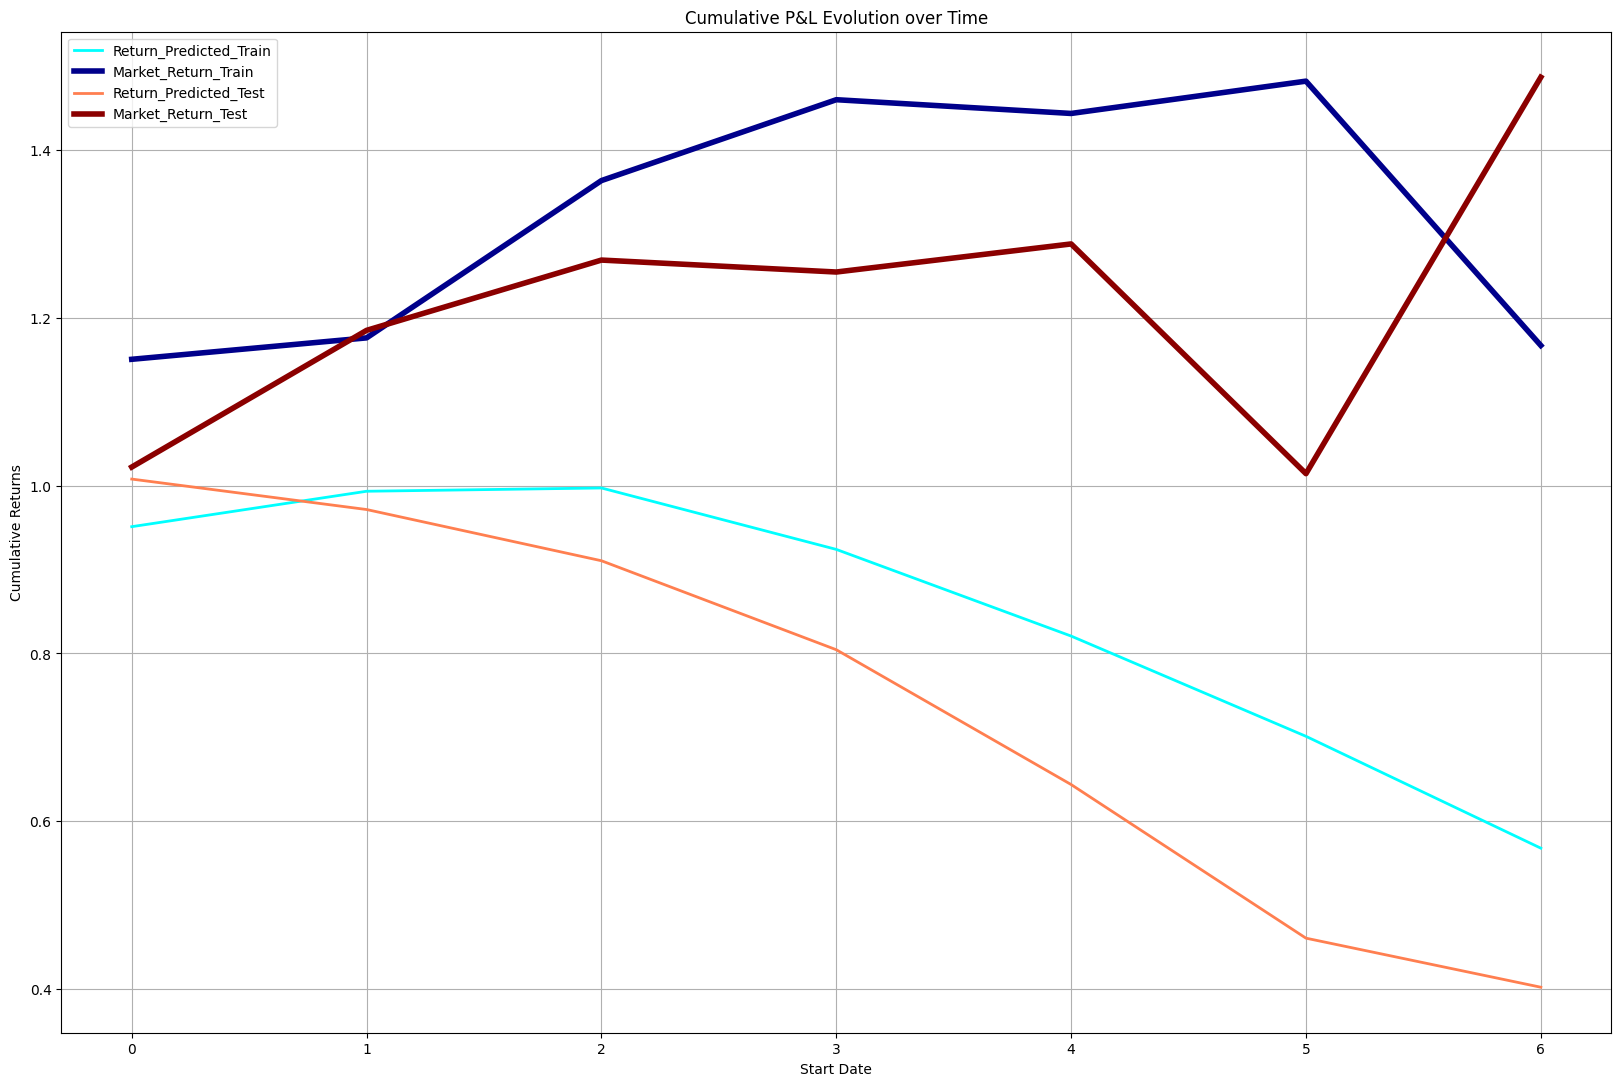

,Start,End,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
0,2006-02-09,2006-08-09,0.951124,1.150644,1.007873,1.022185
1,2006-08-10,2007-02-09,0.993342,1.176171,0.971572,1.185137
2,2007-02-12,2007-08-10,0.997259,1.363671,0.910512,1.268918
3,2007-08-13,2008-02-11,0.924037,1.460072,0.804459,1.254676
4,2008-02-12,2008-08-11,0.820733,1.443685,0.643752,1.288150
5,2008-08-12,2009-02-10,0.701246,1.482201,0.460633,1.014334
6,2009-02-11,2009-08-11,0.567895,1.167136,0.402158,1.486874


In [25]:
#PNL_data.set_index('Start', inplace=True)
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(PNL_data_raw.index, PNL_data_raw['Return_Predicted_Train'], label='Return_Predicted_Train', linewidth=linewidth_model, color='cyan')
plt.plot(PNL_data_raw.index, PNL_data_raw['Market_Return_Train'], label='Market_Return_Train', linewidth=linewidth_market, color='darkblue')
plt.plot(PNL_data_raw.index, PNL_data_raw['Return_Predicted_Test'], label='Return_Predicted_Test', linewidth=linewidth_model, color='coral')
plt.plot(PNL_data_raw.index, PNL_data_raw['Market_Return_Test'], label='Market_Return_Test', linewidth=linewidth_market, color='darkred')
plt.xlabel('Start Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative P&L Evolution over Time')
plt.legend()
plt.grid()
plt.show()
PNL_data_raw

In [45]:
Train_start_list = metrics_perf_df['Train Start'].unique().tolist()
Ticker_per_Period = {}

quantile_above = 0.75
for train_start in Train_start_list:
    quantile_n = metrics_perf_df[metrics_perf_df['Train Start'] == train_start].Ratio_Train.quantile(quantile_above)
    selected_tickers = metrics_perf_df[(metrics_perf_df['Train Start'] == train_start) &
                                       (metrics_perf_df['Ratio_Train'] >= quantile_n)]['Ticker'].tolist()
    Ticker_per_Period[train_start] = selected_tickers

print("Selected Tickers per Training Period:")
for period, tickers in Ticker_per_Period.items():
    print(f"{period}: {tickers}")

Selected Tickers per Training Period:
2005-09-16 00:00:00: ['CDE', 'ORCL', 'AMZN', 'PTEN', 'KMB', 'OXY', 'ERIC', 'MCHP', 'CNC', 'MSFT', 'GGB', 'INTC', 'EQNR', 'AMAT', 'QCOM', 'TSM', 'MU', 'PCG', 'B', 'CSCO', 'HAL', 'HL', 'EXAS', 'BAX', 'BKR', 'BP', 'XOM', 'ABT', 'SHEL', 'LYG', 'TSCO', 'DIS', 'CVX', 'ES', 'KR']
2005-12-15 00:00:00: ['PTEN', 'FHN', 'ERIC', 'CAG', 'MCHP', 'PBR-A', 'GGB', 'PLUG', 'NKE', 'HBAN', 'BAC', 'TU', 'MRVL', 'PBR', 'TSM', 'CTRA', 'DVN', 'CSCO', 'HAL', 'WDC', 'HD', 'IPG', 'VLY', 'UNH', 'EXAS', 'BAX', 'ITUB', 'SHEL', 'CNQ', 'BBD', 'BB', 'CVX', 'IRM', 'TGT', 'T']
2006-03-20 00:00:00: ['PTEN', 'FHN', 'OXY', 'MRK', 'CAG', 'NVO', 'INFY', 'MDLZ', 'MDT', 'GAP', 'TXN', 'KGC', 'EQNR', 'AAPL', 'AMAT', 'BAC', 'TU', 'WMT', 'APH', 'WFC', 'PCG', 'HAL', 'CSX', 'WDC', 'BAX', 'ABT', 'VZ', 'LUV', 'LNW', 'CCJ', 'HPQ', 'HST', 'T', 'LUMN', 'VALE']
2006-06-19 00:00:00: ['ASX', 'FHN', 'ERIC', 'MSTR', 'MDT', 'GSK', 'TXN', 'GGB', 'PLUG', 'NKE', 'F', 'MRVL', 'VTRS', 'MU', 'WMT', 'SONY', 'PFE'

In [53]:
tscv_selected = TimeSeriesSplit(n_splits=tscv_nSplit, max_train_size=window_size)

metrics_perf_selected = []
current_step_selected = 0
total_steps_selected = tscv_selected.get_n_splits(filtered_data)

for train_index, test_index in tscv_selected.split(filtered_data):
    print(f'Processing fold {current_step_selected + 1} of {total_steps_selected}')
    current_step_selected += 1

    train_data, test_data = filtered_data.iloc[train_index], filtered_data.iloc[test_index]
    tickers_in_period = Ticker_per_Period.get(train_data.index.min(), [])

    for ticker in tickers_in_period:
        X_train, Y_train = train_data[ticker].drop(columns=['Signal']), train_data[ticker]['Signal']
        X_test, Y_test = test_data[ticker].drop(columns=['Signal']), test_data[ticker]['Signal']

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit linear regression model
        model = RandomForestClassifier(n_estimators=metrics_perf_df[(metrics_perf_df['Ticker'] == ticker) & (metrics_perf_df['Train Start'] == train_data.index.min())]['n_estimators'].values[0],
                                        random_state=42, n_jobs=-1, ccp_alpha=0.1)
        model.fit(X_train_scaled, Y_train)

        # Make predictions
        Y_train_pred_src = model.predict(X_train_scaled)
        Y_test_pred_src = model.predict(X_test_scaled)

        # Evaluate performance
        Return = np.array(X_test.DD_Return.shift(-1).fillna(0))

        return_predicted_train = float(np.sum(Y_train_pred_src * X_train.DD_Return.shift(-1).fillna(0)))
        return_predicted_test = float(np.sum(Y_test_pred_src * Return))

        market_return_train = float(np.sum(X_train.DD_Return.shift(-1).fillna(0)))
        market_return_test = float(np.sum(Return))

        ratio_train = return_predicted_train / market_return_train if market_return_train != 0 else 0
        ratio_test = return_predicted_test / market_return_test if market_return_test != 0 else 0    
              
        metrics_perf_selected.append({
            'Ticker': ticker,
            'Train Start': train_data.index.min(),
            'Train End': train_data.index.max(),
            'Test Start': test_data.index.min(),
            'Test End': test_data.index.max(),
            'Return_Predicted_Train': return_predicted_train,
            'Return_Predicted_Test': return_predicted_test,
            'Market_Return_Train': market_return_train,
            'Market_Return_Test': market_return_test,
            'Ratio_Train': ratio_train,
            'Ratio_Test': ratio_test,
            'Model_train_>_Market_train': 1 if return_predicted_train > market_return_train else 0,
            'Model_test_>_Market_test': 1 if return_predicted_test > market_return_test else 0,
            'n_estimators': model.n_estimators,
        })

metrics_perf_selected_df = pd.DataFrame(metrics_perf_selected)
metrics_perf_selected_df.to_csv('model/randomforest/metrics_selected_data.csv', index=False)
metrics_perf_selected_df

Processing fold 1 of 79
Processing fold 2 of 79
Processing fold 3 of 79
Processing fold 4 of 79
Processing fold 5 of 79
Processing fold 6 of 79
Processing fold 7 of 79
Processing fold 8 of 79
Processing fold 9 of 79
Processing fold 10 of 79
Processing fold 11 of 79
Processing fold 12 of 79
Processing fold 13 of 79
Processing fold 14 of 79
Processing fold 15 of 79
Processing fold 16 of 79
Processing fold 17 of 79
Processing fold 18 of 79
Processing fold 19 of 79
Processing fold 20 of 79
Processing fold 21 of 79
Processing fold 22 of 79
Processing fold 23 of 79
Processing fold 24 of 79
Processing fold 25 of 79
Processing fold 26 of 79
Processing fold 27 of 79
Processing fold 28 of 79
Processing fold 29 of 79
Processing fold 30 of 79
Processing fold 31 of 79
Processing fold 32 of 79
Processing fold 33 of 79
Processing fold 34 of 79
Processing fold 35 of 79
Processing fold 36 of 79
Processing fold 37 of 79
Processing fold 38 of 79
Processing fold 39 of 79
Processing fold 40 of 79
Processin

,Ticker,Train Start,Train End,Test Start,Test End,Return_Predicted_Train,Return_Predicted_Test,Market_Return_Train,Market_Return_Test,Ratio_Train,Ratio_Test,Model_train_>_Market_train,Model_test_>_Market_test,n_estimators
0,CDE,2005-09-16,2005-12-14,2005-12-15,2006-03-17,-0.288709,-0.149429,-0.020457,0.402594,14.113002,-0.371165,0,0,100
1,ORCL,2005-09-16,2005-12-14,2005-12-15,2006-03-17,-0.104003,0.017426,-0.025026,0.062780,4.155771,0.277571,0,0,100
2,AMZN,2005-09-16,2005-12-14,2005-12-15,2006-03-17,0.295646,-0.050460,0.162287,-0.307388,1.821745,0.164157,1,1,100
3,PTEN,2005-09-16,2005-12-14,2005-12-15,2006-03-17,-0.015174,-0.073507,0.108686,-0.203631,-0.139609,0.360981,0,1,100
4,KMB,2005-09-16,2005-12-14,2005-12-15,2006-03-17,-0.077394,-0.043205,-0.047331,0.015520,1.635166,-2.783925,0,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2760,AZN,2025-03-31,2025-06-30,2025-07-01,2025-09-29,-0.005215,0.014609,-0.039542,0.050572,0.131876,0.288872,1,0,100
2761,TGT,2025-03-31,2025-06-30,2025-07-01,2025-09-29,-0.540976,-0.101788,-0.018799,-0.135644,28.776999,0.750400,0,1,100
2762,TJX,2025-03-31,2025-06-30,2025-07-01,2025-09-29,-0.027436,0.023691,0.022936,0.142756,-1.196176,0.165956,0,0,100
2763,CRM,2025-03-31,2025-06-30,2025-07-01,2025-09-29,-0.038299,-0.086918,0.036648,-0.093245,-1.045045,0.932140,0,1,100


In [54]:
# lets compute the average Return_Predicted_Train and Return_Predicted_Test for Train Start dates batch
summary_graph_selected = metrics_perf_selected_df.groupby(['Train Start', 'Train End', 'Test Start', 'Test End']).agg({
    'Return_Predicted_Train': 'mean',
    'Market_Return_Train': 'mean',
    'Return_Predicted_Test': 'mean',
    'Market_Return_Test': 'mean',
})
summary_graph_selected.to_csv('model/randomforest/metrics_selected_summary.csv', index=True)
summary_graph_selected

,,,,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
Train Start,Train End,Test Start,Test End,,,,
2005-09-16,2005-12-14,2005-12-15,2006-03-17,-0.001371,0.003927,0.025015,0.097008
2005-12-15,2006-03-17,2006-03-20,2006-06-16,0.097424,0.090108,0.052767,-0.054160
2006-03-20,2006-06-16,2006-06-19,2006-09-15,0.046006,0.008365,-0.023030,0.079750
2006-06-19,2006-09-15,2006-09-18,2006-12-14,0.035818,0.051995,-0.005397,0.070454
2006-09-18,2006-12-14,2006-12-15,2007-03-20,0.022476,0.066836,-0.011085,0.008984
...,...,...,...,...,...,...,...
2024-03-27,2024-06-26,2024-06-27,2024-09-25,0.002729,-0.004081,-0.004885,0.047850
2024-06-27,2024-09-25,2024-09-26,2024-12-24,0.013653,0.042097,0.000174,-0.001530
2024-09-26,2024-12-24,2024-12-26,2025-03-28,-0.060758,-0.026693,-0.036807,0.037269


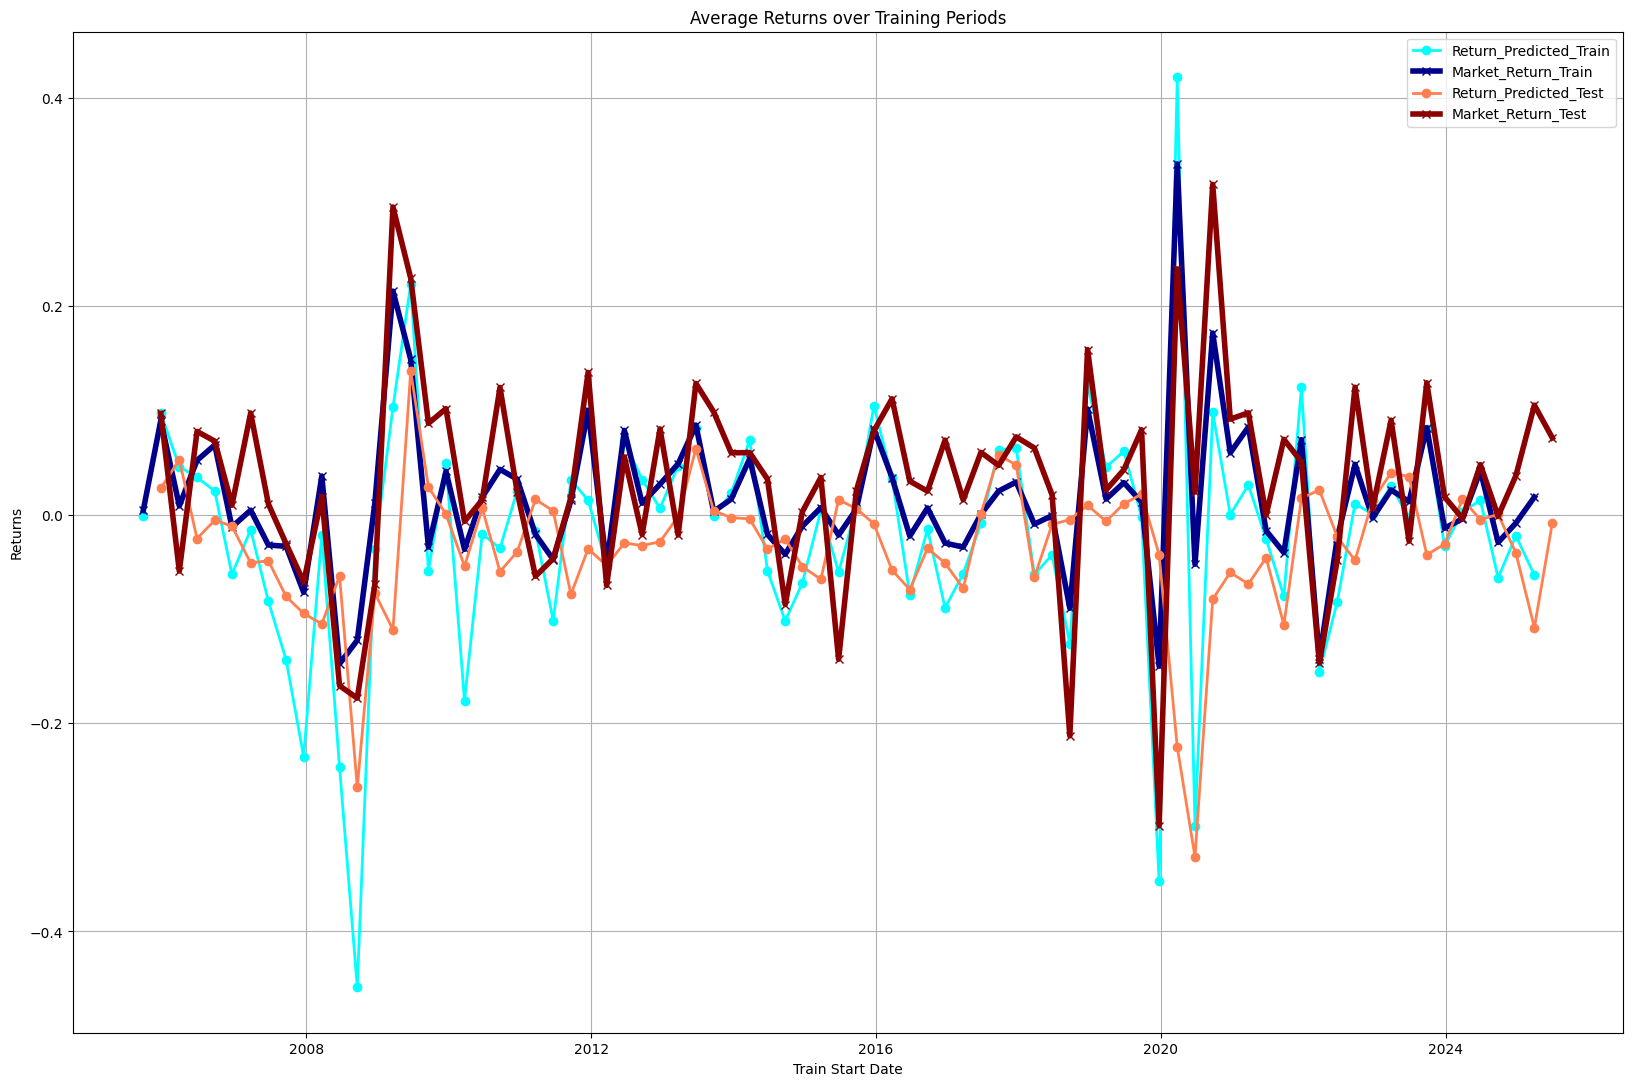

In [55]:
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(summary_graph_selected.index.get_level_values('Train Start'), summary_graph_selected['Return_Predicted_Train'], label='Return_Predicted_Train', marker='o', linewidth=linewidth_model, color='cyan')
plt.plot(summary_graph_selected.index.get_level_values('Train Start'), summary_graph_selected['Market_Return_Train'], label='Market_Return_Train', marker='x', linewidth=linewidth_market, color='darkblue')
plt.plot(summary_graph_selected.index.get_level_values('Test Start'), summary_graph_selected['Return_Predicted_Test'], label='Return_Predicted_Test', marker='o', linewidth=linewidth_model, color='coral')
plt.plot(summary_graph_selected.index.get_level_values('Test Start'), summary_graph_selected['Market_Return_Test'], label='Market_Return_Test', marker='x', linewidth=linewidth_market, color='darkred')
plt.xlabel('Train Start Date')
plt.ylabel('Returns')
plt.title('Average Returns over Training Periods')
plt.legend()
plt.grid()
plt.show()

In [56]:
# Compute yield and std for each series from summary_graph

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    yields = summary_graph_selected[serie].values
    mean_yield = np.mean(yields)
    std_yield = np.std(yields)
    sharpe_ratio = mean_yield / std_yield if std_yield != 0 else 0
    print(f"{serie} - Mean Yield: {mean_yield:.4f}, Std Dev: {std_yield:.4f}, Sharpe Ratio: {sharpe_ratio:.4f}")


Return_Predicted_Train - Mean Yield: -0.0170, Std Dev: 0.1148, Sharpe Ratio: -0.1481
Market_Return_Train - Mean Yield: 0.0152, Std Dev: 0.0714, Sharpe Ratio: 0.2128
Return_Predicted_Test - Mean Yield: -0.0307, Std Dev: 0.0651, Sharpe Ratio: -0.4722
Market_Return_Test - Mean Yield: 0.0338, Std Dev: 0.0980, Sharpe Ratio: 0.3449


In [57]:
# Compute P&L evolution over time for each series
Start_dates = summary_graph_selected.index.get_level_values('Test Start')
End_dates = summary_graph_selected.index.get_level_values('Test End')

Start_End_dates = zip(Start_dates, End_dates)
# Compute P&L evolution over time for each series
PNL_data = summary_graph_selected.reset_index()[['Test Start', 'Test End', 'Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']].rename(columns={'Test Start': 'Start', 'Test End': 'End'})
for start, end in Start_End_dates:
    for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
        PNL_data.loc[(PNL_data['Start'] == start) & (PNL_data['End'] == end), serie] = summary_graph_selected.loc[(summary_graph_selected.index.get_level_values('Test Start') == start) & (summary_graph_selected.index.get_level_values('Test End') == end), serie].values[0]

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    PNL_data[serie] = np.exp(PNL_data[serie])
    PNL_data[serie] = PNL_data[serie].cumprod()

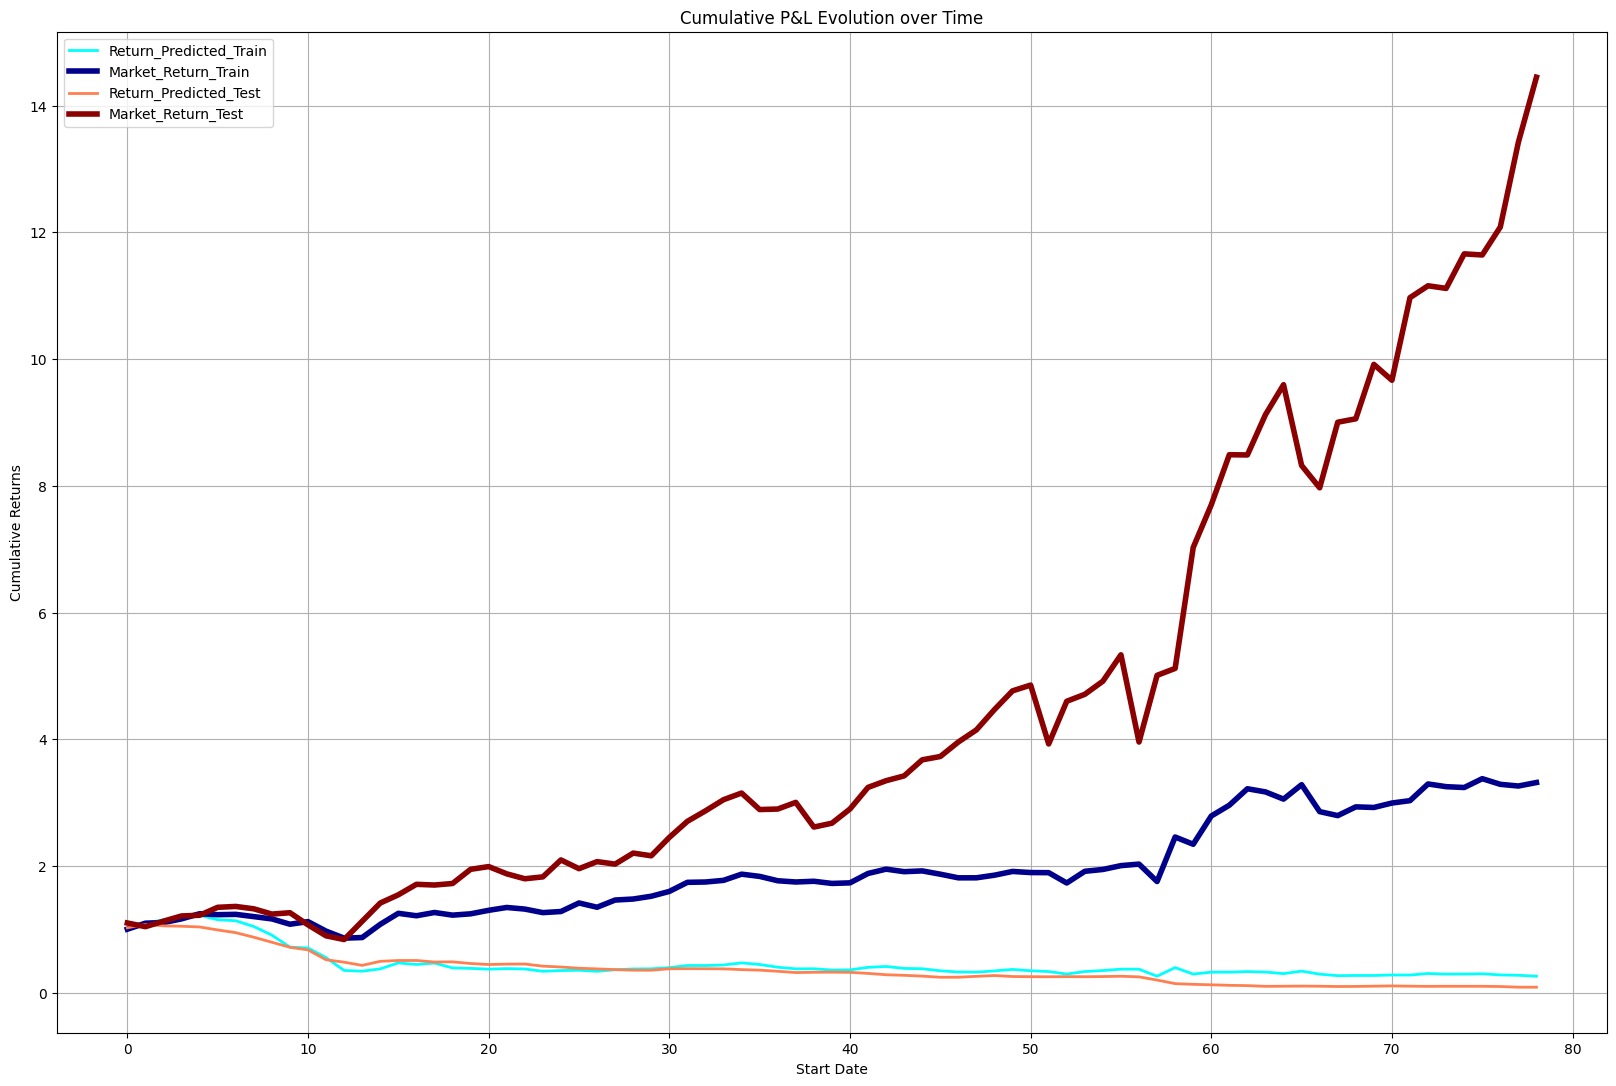

,Start,End,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
0,2005-12-15,2006-03-17,0.998630,1.003935,1.025331,1.101869
1,2006-03-20,2006-06-16,1.100818,1.098598,1.080887,1.043780
2,2006-06-19,2006-09-15,1.152646,1.107827,1.056279,1.130430
3,2006-09-18,2006-12-14,1.194680,1.166952,1.050594,1.212946
4,2006-12-15,2007-03-20,1.221835,1.247612,1.039012,1.223893
...,...,...,...,...,...,...
74,2024-06-27,2024-09-25,0.296001,3.239577,0.102834,11.660453
75,2024-09-26,2024-12-24,0.300070,3.378865,0.102852,11.642628
76,2024-12-26,2025-03-28,0.282381,3.289866,0.099135,12.084720
77,2025-03-31,2025-06-30,0.276708,3.263064,0.088942,13.422463


In [58]:
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(PNL_data.index, PNL_data['Return_Predicted_Train'], label='Return_Predicted_Train', linewidth=linewidth_model, color='cyan')
plt.plot(PNL_data.index, PNL_data['Market_Return_Train'], label='Market_Return_Train', linewidth=linewidth_market, color='darkblue')
plt.plot(PNL_data.index, PNL_data['Return_Predicted_Test'], label='Return_Predicted_Test', linewidth=linewidth_model, color='coral')
plt.plot(PNL_data.index, PNL_data['Market_Return_Test'], label='Market_Return_Test', linewidth=linewidth_market, color='darkred')
plt.xlabel('Start Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative P&L Evolution over Time')
plt.legend()
plt.grid()
plt.show()
PNL_data

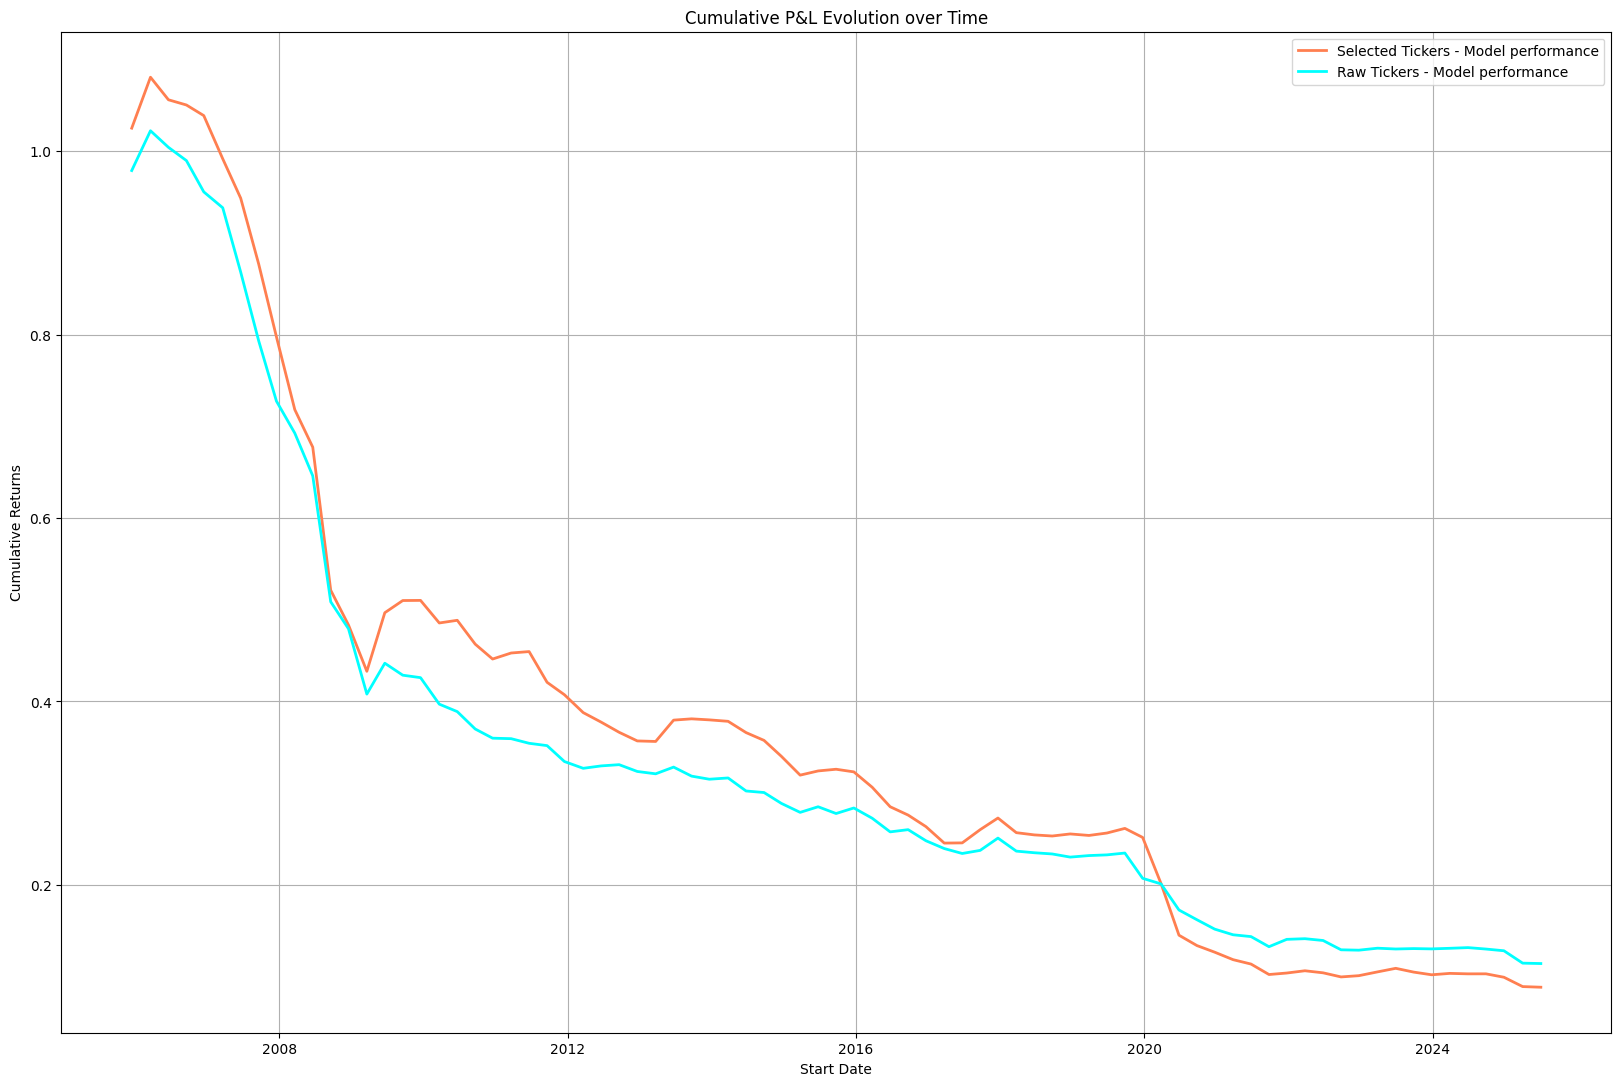

In [59]:
# Compare PNL data between raw and selected tickers

plt.figure(figsize=(20, 13))

plt.plot(PNL_data.set_index('Start').index, PNL_data['Return_Predicted_Test'], label='Selected Tickers - Model performance', linewidth=linewidth_model, color='coral')
#plt.plot(data_plot.index, data_plot['Market_Return_Test'], label='Selected Tickers - Market performance', linewidth=linewidth_market, color='darkred')

plt.plot(PNL_data_raw.set_index('Start').index, PNL_data_raw['Return_Predicted_Test'], label='Raw Tickers - Model performance', linewidth=linewidth_model, color='cyan')
#plt.plot(PNL_data_raw.index, PNL_data_raw['Market_Return_Test'], label='Raw Tickers - Market performance', linewidth=linewidth_market, color='darkblue')

plt.xlabel('Start Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative P&L Evolution over Time')
plt.legend()
plt.grid()
plt.show()
